---
### **<p style="text-align: center; text-decoration: underline;">Kernel Machines</p>**
# **<p style="text-align: center;">Practical: Ridge Regression & Kernelized Tykhonov Regularization</p>**
---

> Realized by: Zakaria Boulkhir & Omar Iken.
### ■ __Overview__
In this notebook, we will see Ridge Regression & Kernelized Tykhonov Regularization

### ■ **<a name="content">Contents</a>**

- [1. Drawing the dataset](#dataset)

- [2. Linear Regression](#linearregression)

- [3. Kernel Ridge Regression](#KRR)

### ■ **Libraries**

In [1]:
## numpy to handle arrays & matices
import numpy as np

## matplotlib & Seaborn to plot figures
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn dependencies
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import PolynomialFeatures

#-----------< Setting >------------#
## set plots text font size & style
sns.set(font_scale=1.2, style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

### ■ __Kernels & Gram Matrix__
Let's start by defining different kernels that we will be using in this work:

In [2]:
def linear_kernel(a, b):
    """linear kernel"""
    return np.inner(a, b)

def polynomial_kernel(a, b, c, d):
    """Polynomial kernel"""
    return (np.inner(a, b) + c) ** d

def gaussian_kernel(a, b):
    """Gaussian kernel"""
    return np.exp(-.5 * np.linalg.norm((a - b)**2))

def laplace_kernel(a, b):
    """Laplce kernel"""
    return np.exp(-np.linalg.norm(a - b, ord=1))

def exponential_kernel(a, b):
    """Exponential kernel"""
    return np.exp(np.inner(a, b))

def gram_matrix(X, kernel):
    """returns Gram matrix of X using the given kernel"""
    n, _ = X.shape
    K = np.array([kernel(X[i], X[j]) 
                  for i in range(n)
                  for j in range(n)]).reshape(n, n)
    return K

### ■ **<a name="dataset">1. Dataset</a>** [(&#8593;)](#content)
Tn this first section, we start by generating random samples $(x_i, y_i)\in \mathbb{R}^2)$, where $x_i\in[-5, 5]$ and $y_i=(x_i+4)(x_i+1)(x_i-1)(x_i-3) + \epsilon_i$, and $\epsilon_i \sim \mathcal{N}(0, 1)$ denotes an independant Gaussian random noise.

The polynomial is given explicitly by $y=(x+4)(x+1)(x-1)(x-3)=x^4 + x^3 -13x^2 - x + 12$, which means that it's of degree $4$.

#### **1.1. Generate data**
Let's generate training & validation datasets.

In [3]:
## Number of training & validation samlples
n_samples = 1_000
n_val = 2_000

## intervals edges
a, b = -5, 5

## generate training & validation samples in [a, b]
X = a + (b - a) * np.random.rand(n_samples)
X_val = a + (b - a) * np.random.rand(n_val)
# X = np.random.uniform(-5, 5, 2000)

## generate epsilon as gaussian random noise N(0, 1)
eps = np.random.normal(loc=0, scale=1, size=n_samples)
eps_val = np.random.normal(loc=0, scale=5, size=n_val)

## generate y defined as follows: y_i = (x_i+4)*(x_i+1)*(x_i-1)*(x_i-3) + eps_i
y = (X + 4) * (X + 1) * (X - 1) * (X - 3) + eps
y_val = (X_val + 4) * (X_val + 1) * (X_val - 1) * (X_val - 3) + eps_val

#### **1.2. Display data**
Here is a picture of the generated data.

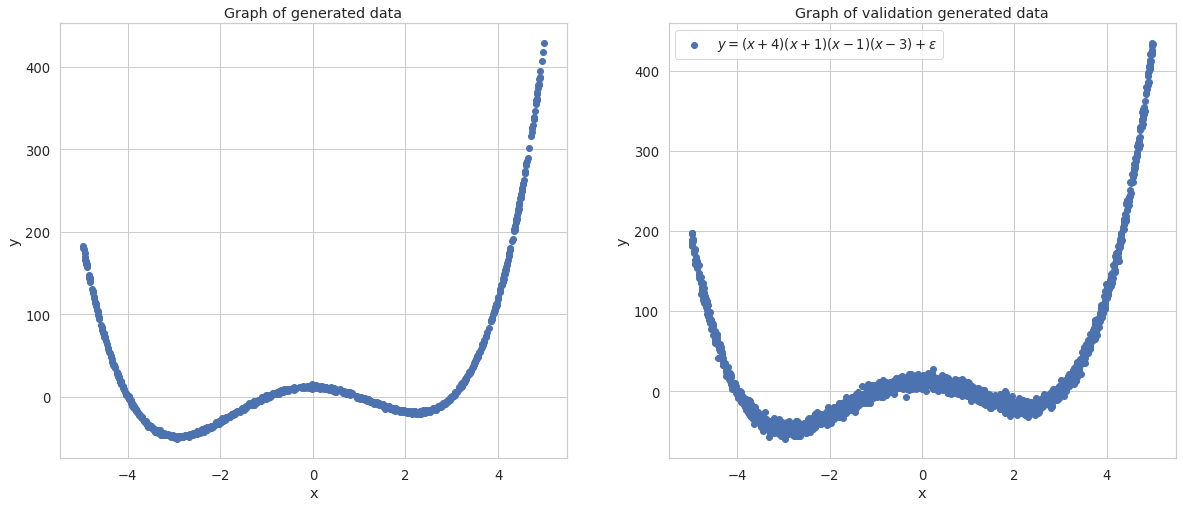

In [4]:
## display data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax1.scatter(X, y, label=r"$y = (x+4)(x+1)(x-1)(x-3) + \epsilon$")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Graph of generated data')

ax2.scatter(X_val, y_val, label=r"$y = (x+4)(x+1)(x-1)(x-3) + \epsilon$")
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Graph of validation generated data')

plt.legend()
plt.show()

### ■ **<a name="linearregression">2. Linear Regression</a>** [(&#8593;)](#content)
In this section, we will apply & evaluate Linear Regression model on the data generated earlier.

#### **2.1. Linear model on generated data**
Let's apply a linear regression model on our generated dataset.

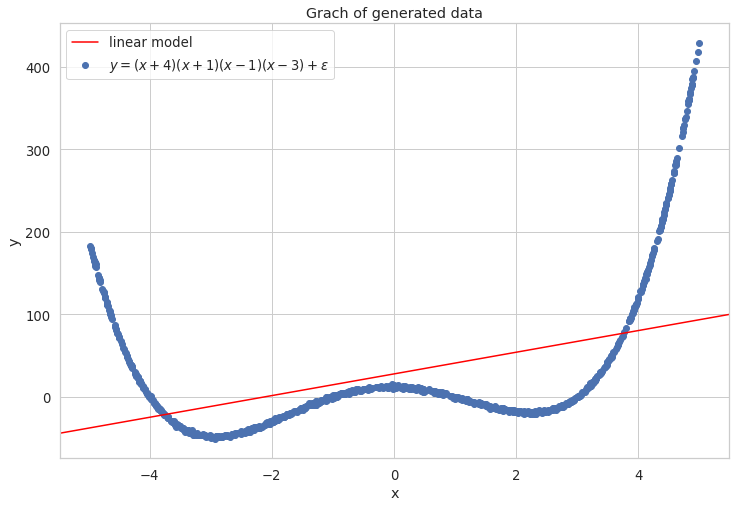

In [5]:
## create & fit a linear model
linear_model = LinearRegression()
linear_model.fit(X.reshape(-1, 1), y)

## get fitted model parameters
alpha = linear_model.coef_[0]
beta = linear_model.intercept_

## plot regression line
plt.axline((0, beta), slope=alpha, color='red', label='linear model')
## plot data
plt.scatter(X, y, label=r"$y = (x+4)(x+1)(x-1)(x-3) + \epsilon$")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Grach of generated data')
plt.legend()
plt.show()

**Comment:** Underfitting, traying to model a non linear data with a linear model !

#### **2.2. Model Evaluation**
To evaluate our linear model, we will the compute the prediction error for both training & validation sets.

In [6]:
## make X validation predictions
y_pred = linear_model.predict(X.reshape(-1, 1))
y_pred_val = linear_model.predict(X_val.reshape(-1, 1))

## compute prediction error
train_error = mean_absolute_error(y, y_pred)
val_error = mean_absolute_error(y_val, y_pred_val)

##
print(f'Training error  : {train_error}')
print(f'Validation error: {val_error}')

Training error  : 55.96002694440074
Validation error: 56.07202644119288


**Comments:**  
- The prediction error is very large, which is due to the fact that we are trying to model a non linear data with a linear model (Underfitting).
- This is not a valuable contribution, we can do better by using some more 'non linear' models.

#### **2.3. Alternative Strategy**
As the linear model seems not to be a good choice to model our problem, we suggest an alternative strategy to get reasonable results in estimating a complex non-linear function. The most obvious idea is to think about a change of basis for functions that could serve to estimate the complex function. This obvious model in our case is a polynomial regression which will serve to model the underlying problem.

degree: 2--------- -train_error: 42.0223056689459, -validation error: 42.69593619730885
degree: 3--------- -train_error: 39.754198881464944, -validation error: 40.774260333695025
degree: 4--------- -train_error: 0.7916622197223014, -validation error: 4.051810129723149
degree: 5--------- -train_error: 0.7916835990349672, -validation error: 4.051573182067372


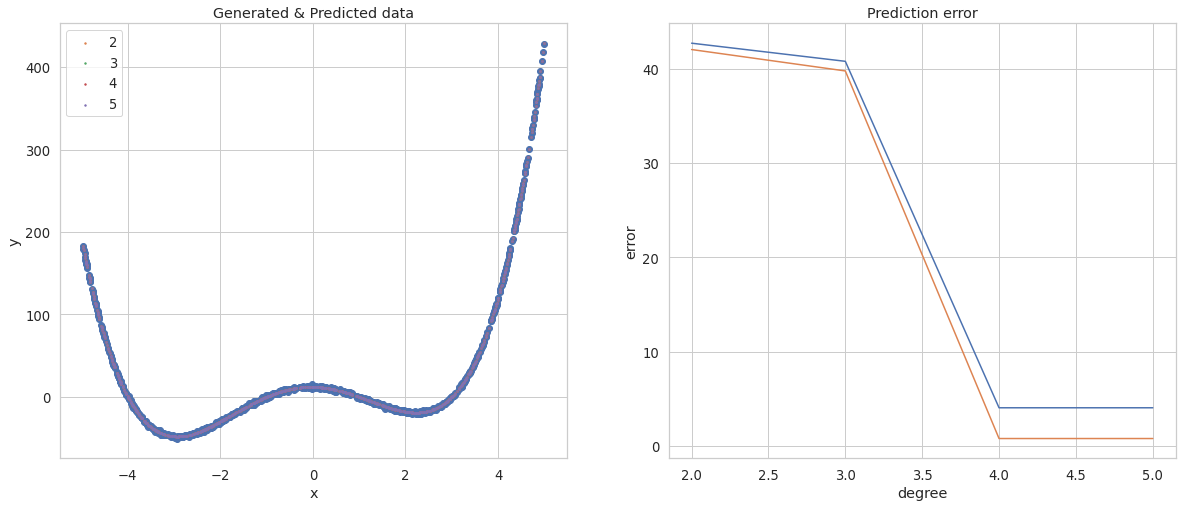

In [7]:
## list of degrees to test
degrees = [2, 3, 4, 5]

## arrays for errors
train_errors = []
val_errors = []
pred_ys = []

## for each degree
for degree in degrees:

    ## create a polynomial model
    pol_model = PolynomialFeatures(degree=degree)

    ## transfrom input data
    X_pol = pol_model.fit_transform(X.reshape(-1, 1), y)
    X_val_pol = pol_model.transform(X_val.reshape(-1, 1))

    ## fit the polynomial model
    pol_model.fit(X.reshape(-1, 1), y)

    ## apply this model to linear model
    linear_model.fit(X_pol, y)
    
    ## make predictions
    y_pol_pred = linear_model.predict(X_pol)
    y_pol_val_pred = linear_model.predict(X_val_pol)
    pred_ys.append(y_pol_pred)
    
    ## compute errors
    train_error = mean_absolute_error(y, y_pol_pred)
    val_error = mean_absolute_error(y_val, y_pol_val_pred)
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    print(f'degree: {degree:-<10} -train_error: {train_error}, -validation error: {val_error}')
    
## plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
ax1.scatter(X, y)
for e, degree in enumerate(degrees):    
    ax1.scatter(X, y_pol_pred, label=str(degree), s=2)
ax1.set_title('Generated & Predicted data')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend()

ax2.plot(degrees, val_errors, label='validation error')
ax2.plot(degrees, train_errors, label='training error')
ax2.set_xlabel('degree')
ax2.set_ylabel('error')
ax2.set_title('Prediction error')

plt.show()

**Comments:**
- Polynomial regression with degree 4 seems to better fit the data.
- It seems that from degree 5 and beyonds the model overfits.

### ■ **<a name="KRR">3. Kernel Ridge Regression</a>** [(&#8593;)](#content)
In this last section, we will apply Kernel Ridge Regression to our dataset, by using both Polynomial & Gaussian kernels.
#### **3.1. Polynomial Kernel**

degree: 1--------- -train score: 0.1881, -train_error: 55.9462    -val score: 0.2084, -val error: 56.0578
degree: 2--------- -train score: 0.6766, -train_error: 42.0155    -val score: 0.6819, -val error: 42.6876
degree: 3--------- -train score: 0.7201, -train_error: 39.7499    -val score: 0.7254, -val error: 40.7656
degree: 4--------- -train score: 0.9999, -train_error: 0.7917    -val score: 0.9969, -val error: 4.0512
degree: 5--------- -train score: 0.9999, -train_error: 0.7919    -val score: 0.9969, -val error: 4.051
degree: 6--------- -train score: 0.9999, -train_error: 0.7917    -val score: 0.9969, -val error: 4.0512


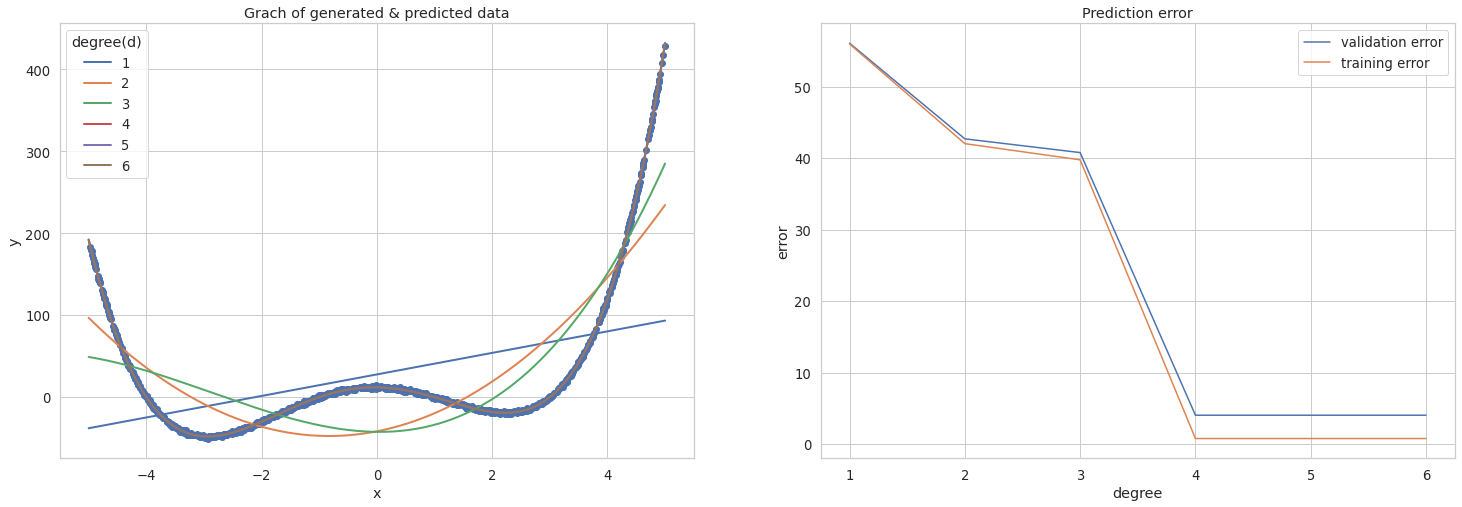

In [17]:
## parameters
alpha = 1.
kernel = 'polynomial'
degrees = [1, 2, 3, 4, 5, 6]

## predicted y
pred_ys = []
train_errors = []
val_errors = []

## define X for ploting
X_plot = np.linspace(-5, 5, 1000)[:, None]

## for each degree
for degree in degrees:
    ## create & fit a KR model
    kr = KernelRidge(alpha=alpha, kernel=kernel, degree=degree)
    kr.fit(X.reshape(-1, 1), y)

    ## score
    train_score = np.round(kr.score(X.reshape(-1, 1), y), 4)
    train_error = np.round(mean_absolute_error(y, kr.predict(X.reshape(-1, 1))), 4)
    val_score = np.round(kr.score(X_val.reshape(-1, 1), y_val), 4)
    val_error = np.round(mean_absolute_error(y_val, kr.predict(X_val.reshape(-1, 1))), 4)
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    print(f'degree: {degree:-<10} -train score: {train_score}, -train_error: {train_error}\
    -val score: {val_score}, -val error: {val_error}')
    
    ## predictions
    y_kr = kr.predict(X_plot)
    pred_ys.append(y_kr)
    
    
## plot results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
ax1.scatter(X, y)
for e, degree in enumerate(degrees):
    ax1.plot(X_plot, pred_ys[e], lw=2, label=str(degree))
ax1.set_title('Grach of generated & predicted data')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend(title='degree(d)')

ax2.plot(degrees, val_errors, label='validation error')
ax2.plot(degrees, train_errors, label='training error')
ax2.set_xlabel('degree')
ax2.set_ylabel('error')
ax2.set_title('Prediction error')
ax2.legend()
plt.show()

**Comments:**
- The degrees 1, 2 and 3 are not good choice for the polynomial kernel degree, since the prediction error is very large for these values.
- 4 is a good choice of the degree of the polynomial kernel. Going furhter risks to lead us to overfitting (Remark from computing manually the mean absolute error).
- The probelm at hand is of degree 4, and it only seems logical to have a model as complex as the problem (same polynomial degree).
- For d=1, the problem is way more complex than the problem we are trying to solve. 

#### **3.2. Gaussian kernel**
Now, let's repeat the previous work but replacing the above polynomial kernel by a Gaussian one for different bandwidth values.

gamma: 0.001----- -train score: 0.272, -train_error: 51.563    -val score: 0.286, -val error: 51.82
gamma: 0.01------ -train score: 0.648, -train_error: 42.104    -val score: 0.651, -val error: 42.864
gamma: 1--------- -train score: 0.996, -train_error: 2.485    -val score: 0.991, -val error: 5.42
gamma: 2--------- -train score: 0.997, -train_error: 1.963    -val score: 0.992, -val error: 5.087
gamma: 5--------- -train score: 0.997, -train_error: 1.649    -val score: 0.991, -val error: 4.982
gamma: 10-------- -train score: 0.997, -train_error: 1.625    -val score: 0.991, -val error: 5.008
gamma: 20-------- -train score: 0.997, -train_error: 1.83    -val score: 0.989, -val error: 5.229
gamma: 100------- -train score: 0.993, -train_error: 3.051    -val score: 0.983, -val error: 6.339
gamma: 400------- -train score: 0.983, -train_error: 5.257    -val score: 0.962, -val error: 9.027


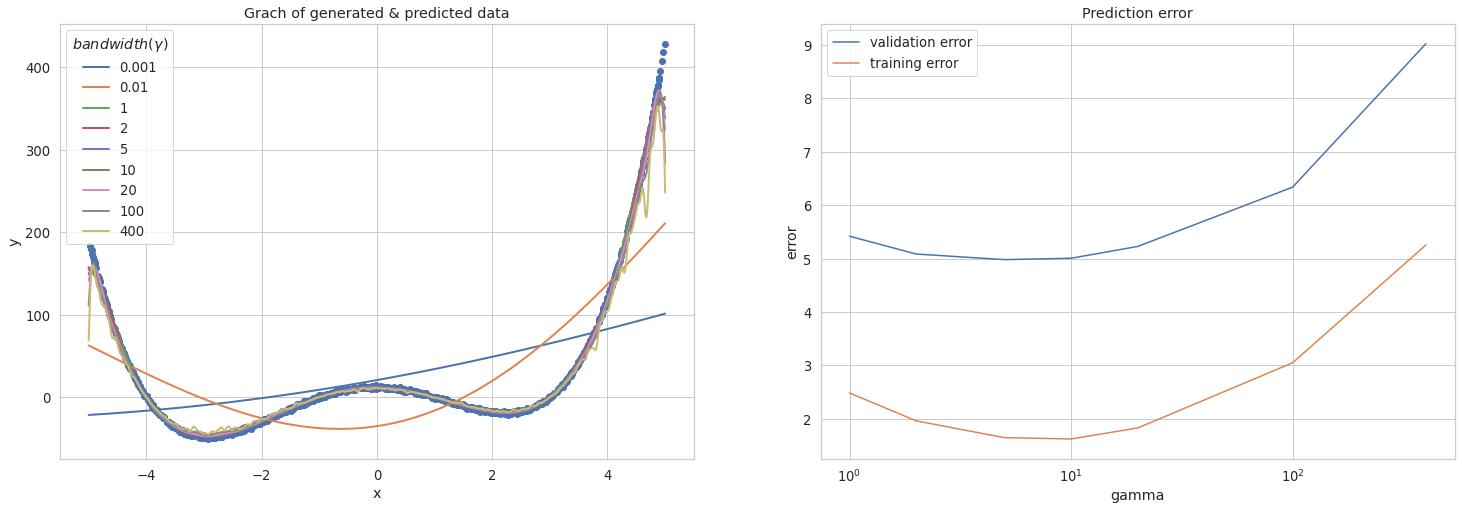

In [16]:
## parameters
alpha = 1.
kernel = 'rbf'
gammas = [.001, .01, 1, 2, 5, 10, 20, 100, 400]# + list(range(1, 11))

## predicted y
pred_ys = []
train_errors = []
val_errors = []

## define X for ploting
X_plot = np.linspace(-5, 5, 1000)[:, None]

## for each degree
for gamma in gammas:
    ## create & fit a KR model
    kr = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)
    kr.fit(X.reshape(-1, 1), y)

    ## score
    train_score = np.round(kr.score(X.reshape(-1, 1), y), 3)
    train_error = np.round(mean_absolute_error(y, kr.predict(X.reshape(-1, 1))), 3)
    val_score = np.round(kr.score(X_val.reshape(-1, 1), y_val), 3)
    val_error = np.round(mean_absolute_error(y_val, kr.predict(X_val.reshape(-1, 1))), 3)
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    print(f'gamma: {gamma:-<10} -train score: {train_score}, -train_error: {train_error}\
    -val score: {val_score}, -val error: {val_error}')
    
    ## predictions
    y_kr = kr.predict(X_plot)
    pred_ys.append(y_kr)

## plot results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
ax1.scatter(X, y)
for e, gamma in enumerate(gammas):
    ax1.plot(X_plot, pred_ys[e], lw=2, label=str(gamma))
ax1.set_title('Grach of generated & predicted data')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.legend(title='$bandwidth(\gamma)$')

ax2.plot(gammas[2:], val_errors[2:], label='validation error')
ax2.plot(gammas[2:], train_errors[2:], label='training error')
ax2.set_xlabel('gamma')
ax2.set_ylabel('error')
ax2.set_title('Prediction error')
ax2.set_xscale('log')
ax2.legend()
plt.show()

**Comments:**
- The gaussian kenel with bandwidth $\gamma=10^{-3}$ ressembles to the polynomial kernel with degree $d=1$. Same goes for the gaussian kenel with bandwidth $\gamma=10^{-2}$ that ressembles to the polynomial kernel with degrees $d=2$.
- For very large values of bandwidth (e.g. $\gamma=100$), the model tends to overfit the noise in the dataset. [An apparent remark, that we tried explaining theoritically. However, we didn't end up finding the same reasoning as the $\gamma$ reduces the effect of the metric rather than amplifying it.]
- The value $\gamma=10$, seem to be a good choice for the gaussian kernel.

#### **3.3. Choosing the Best Regularization Parameter**
We are looking to choose the best regularization parameter $\alpha$ for the previously drawn dataset.

##### **3.3.1. Polynomial kernel**

alpha: 0.0001---- -train score: 1.0, -train_error: 0.792    -val score: 0.997, -val error: 4.052
alpha: 0.001----- -train score: 1.0, -train_error: 0.792    -val score: 0.997, -val error: 4.052
alpha: 0.01------ -train score: 1.0, -train_error: 0.792    -val score: 0.997, -val error: 4.052
alpha: 0.1------- -train score: 1.0, -train_error: 0.792    -val score: 0.997, -val error: 4.052
alpha: 0.2------- -train score: 1.0, -train_error: 0.792    -val score: 0.997, -val error: 4.052
alpha: 1--------- -train score: 1.0, -train_error: 0.792    -val score: 0.997, -val error: 4.051
alpha: 10-------- -train score: 1.0, -train_error: 0.81    -val score: 0.997, -val error: 4.053


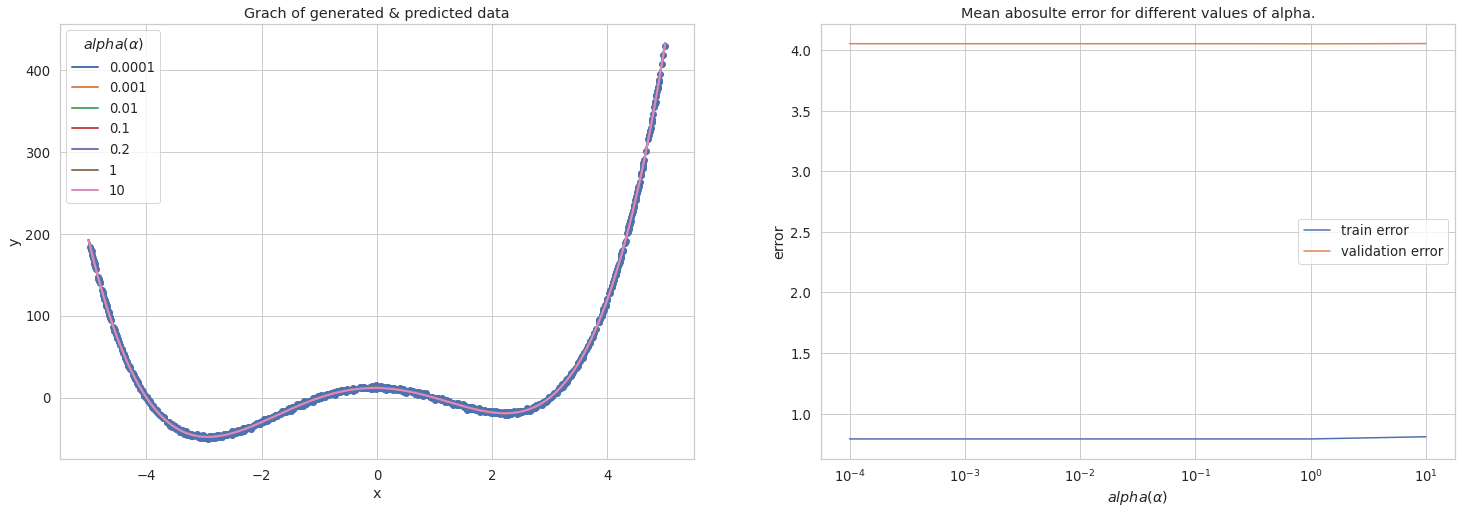

In [10]:
## alpha values
alphas = [.0001, .001, .01, .1, .2, 1, 10]
    
## parameters
kernel = 'polynomial'
degree = 4

## arrays to store results
train_errors = []
val_errors = []
pred_ys = []


## define X for ploting
X_plot = np.linspace(-5, 5, 1000)[:, None]

## for each alpha
for alpha in alphas:
    ## create & fit a KR model
    kr = KernelRidge(alpha=alpha, kernel=kernel, degree=degree)
    kr.fit(X.reshape(-1, 1), y)

    ## score
    train_score = np.round(kr.score(X.reshape(-1, 1), y), 3)
    train_error = np.round(mean_absolute_error(y, kr.predict(X.reshape(-1, 1))), 3)
    val_score = np.round(kr.score(X_val.reshape(-1, 1), y_val), 3)
    val_error = np.round(mean_absolute_error(y_val, kr.predict(X_val.reshape(-1, 1))), 3)
    
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    print(f'alpha: {alpha:-<10} -train score: {train_score}, -train_error: {train_error}\
    -val score: {val_score}, -val error: {val_error}')
    
    ## predictions
    y_kr = kr.predict(X_plot)
    pred_ys.append(y_kr)
    
## display results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(25, 8))
for e, alpha in enumerate(alphas):
    ax1.plot(X_plot, pred_ys[e], lw=2, label=str(alpha))
    
ax1.scatter(X, y)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Grach of generated & predicted data')

ax2.plot(alphas, train_errors, label='train error')
ax2.plot(alphas, val_errors, label='validation error')
ax2.set_xlabel(r'$alpha(\alpha)$')
ax2.set_ylabel('error')
ax2.set_xscale('log')
ax2.set_title('Mean abosulte error for different values of alpha.')

ax1.legend(title=r'$alpha(\alpha)$')
ax2.legend()
plt.show()

**Comment:** For polynomial kernel, the alpha parameter has no or very negligible effect on the results.

##### **3.3.2. Gaussian kernel**

alpha: 0.0001---- -train score: 1.0, -train_error: 0.82    -val score: 0.997, -val error: 4.074
alpha: 0.001----- -train score: 1.0, -train_error: 0.987    -val score: 0.997, -val error: 4.164
alpha: 0.01------ -train score: 0.999, -train_error: 1.722    -val score: 0.996, -val error: 4.55
alpha: 0.1------- -train score: 0.996, -train_error: 3.633    -val score: 0.992, -val error: 5.86
alpha: 0.2------- -train score: 0.993, -train_error: 4.491    -val score: 0.989, -val error: 6.516
alpha: 1--------- -train score: 0.97, -train_error: 10.132    -val score: 0.965, -val error: 11.128
alpha: 10-------- -train score: 0.848, -train_error: 20.903    -val score: 0.84, -val error: 22.248
alpha: 100------- -train score: 0.452, -train_error: 41.37    -val score: 0.446, -val error: 42.009


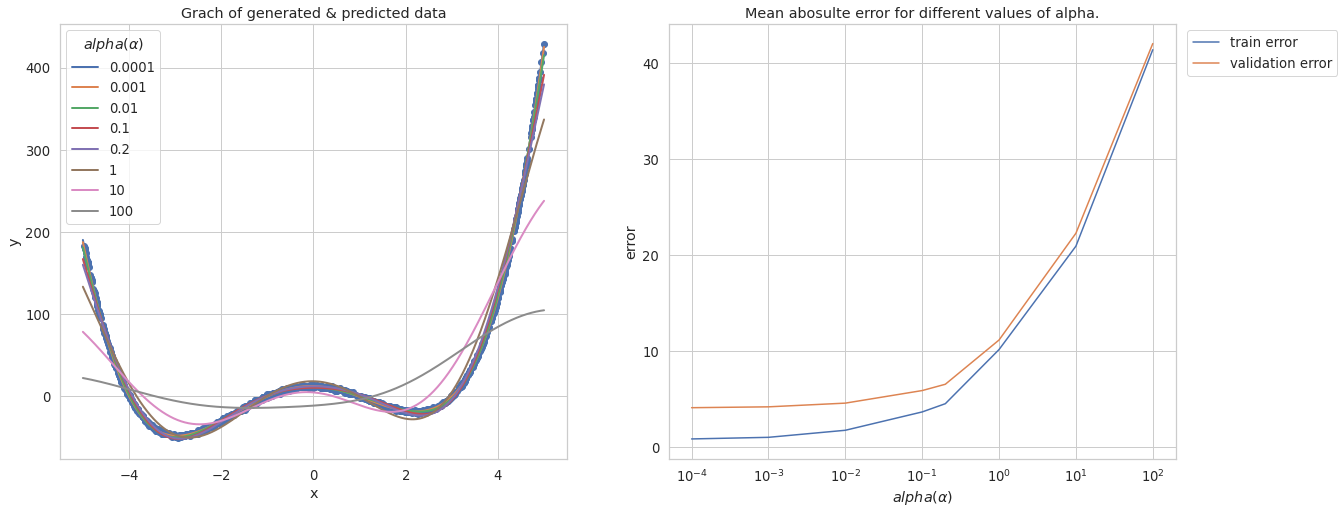

In [11]:
## alpha values
alphas = [.0001, .001, .01, .1, .2, 1, 10, 100]
    
## parameters
alpha = 1.
kernel = 'rbf'
gamma = .1

## arrays to store results
train_errors = []
val_errors = []
pred_ys = []

## define X for ploting
X_plot = np.linspace(-5, 5, 1000)[:, None]

## for each alpha
for alpha in alphas:
    ## create & fit a KR model
    kr = KernelRidge(alpha=alpha, kernel=kernel, gamma=gamma)
    kr.fit(X.reshape(-1, 1), y)

    ## score
    train_score = np.round(kr.score(X.reshape(-1, 1), y), 3)
    train_error = np.round(mean_absolute_error(y, kr.predict(X.reshape(-1, 1))), 3)
    val_score = np.round(kr.score(X_val.reshape(-1, 1), y_val), 3)
    val_error = np.round(mean_absolute_error(y_val, kr.predict(X_val.reshape(-1, 1))), 3)
    
    train_errors.append(train_error)
    val_errors.append(val_error)
    
    print(f'alpha: {alpha:-<10} -train score: {train_score}, -train_error: {train_error}\
    -val score: {val_score}, -val error: {val_error}')
    
    ## predictions
    y_kr = kr.predict(X_plot)
    pred_ys.append(y_kr)
    
## display results
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
for e, alpha in enumerate(alphas):
    ax1.plot(X_plot, pred_ys[e], lw=2, label=str(alpha))
    
ax1.scatter(X, y)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Grach of generated & predicted data')

ax2.plot(alphas, train_errors, label='train error')
ax2.plot(alphas, val_errors, label='validation error')
ax2.set_xlabel(r'$alpha(\alpha)$')
ax2.set_ylabel('error')
ax2.set_xscale('log')
ax2.set_title('Mean abosulte error for different values of alpha.')

ax1.legend(title=r'$alpha(\alpha)$')
ax2.legend(bbox_to_anchor=(1.01, 1))
plt.show()

**Comments:** 
- We did not get the same value for alpha ($\alpha$) for gaussian kernel as for polynomial kernel.
- Unlike the polynomial kernel, the parameter alpha ($\alpha$) has a significant impact on the results of the gaussian kernel.
- As it seems, for the gaussian, the smaller the alpha value, the better the score within a certain limiting lower bound (due to the noise).
- We justify this phenomenon by the fact that the gaussian kernel tends to learn the noise and therefore it is not prone to "put to zero" any added "constant" terms to the problem. We could say the opposite for the polynomials as they tend to rather nulify the constant term (noise + regularization term).

---
<p style="text-align: center;">Copyright © 2021 Omar Ikne & Zakaria Boulkhir</p>